Object detection [Classification + Localiazation]

1: Importing libraries

In [699]:
import os
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image , PIL.ImageFont , PIL.ImageDraw
import tensorflow as tf
import tensorflow_datasets as tfds

2: Visualization Utilities

In [702]:
im_width = 75
im_height = 75
use_normalized_coordinates = True

In [704]:
def draw_bounding_boxes_on_image_array(image, boxes, color=[], thickness=1, display_str_list=()):
    image_pil = PIL.Image.fromarray(image.astype(np.uint8))
    if image_pil.mode == 'L':
        rgbimg = PIL.Image.new("RGB", image_pil.size)
        rgbimg.paste(image_pil)
    elif image_pil.mode == 'RGBA':
        rgbimg = image_pil.convert('RGB')
    else:
        rgbimg = image_pil.copy()

    draw_bounding_boxes_on_image(
        image=rgbimg,
        boxes=boxes,
        color=color,
        thickness=thickness,
        display_str_list=display_str_list
    )
    return np.array(rgbimg)

def draw_bounding_boxes_on_image(image, boxes, color=[], thickness=1, display_str_list=()):
    boxes_shape = boxes.shape
    if not isinstance(boxes, np.ndarray) or len(boxes_shape) != 2 or boxes_shape[1] != 4:
        if isinstance(boxes, np.ndarray) and boxes.size == 0 and (len(boxes_shape) == 1 or (len(boxes_shape) == 2 and boxes_shape[1] == 0)):
            pass
        else:
            raise ValueError(f"Input boxes must be of shape [N, 4], got {boxes_shape}")


    for i in range(boxes_shape[0]):
        ymin, xmin, ymax, xmax = boxes[i]
        draw_single_box_on_image(
            image=image,
            ymin=ymin,
            xmin=xmin,
            ymax=ymax,
            xmax=xmax,
            color=color[i] if i < len(color) else "red",
            thickness=thickness,
            display_str=display_str_list[i] if i < len(display_str_list) else None
        )

def draw_single_box_on_image(image, ymin, xmin, ymax, xmax, color='red', thickness=1, display_str=None, use_normalized_coordinates=True): 
    draw = PIL.ImageDraw.Draw(image)
    im_width_pil, im_height_pil = image.size 

    if use_normalized_coordinates:
        left = float(xmin) * im_width_pil
        right = float(xmax) * im_width_pil
        top = float(ymin) * im_height_pil
        bottom = float(ymax) * im_height_pil
    else:
        left = float(xmin)
        right = float(xmax)
        top = float(ymin)
        bottom = float(ymax)

    thickness_to_draw = max(1, int(thickness))
    draw.line(
        [(left, top), (left, bottom), (right, bottom), (right, top), (left, top)],
        width=thickness_to_draw,
        fill=color
    )
    if display_str:
        try:
            font = PIL.ImageFont.truetype("arial.ttf", 12)
        except IOError:
            font = PIL.ImageFont.load_default()
        
        text_left = left + thickness_to_draw
        text_top = top - 12 if top > 12 else top + thickness_to_draw 

        if hasattr(font, "getbbox"): # For Pillow >= 9.2.0
             text_bbox = font.getbbox(display_str)
             text_width = text_bbox[2] - text_bbox[0]
             text_height = text_bbox[3] - text_bbox[1]
        elif hasattr(font, "getsize"): # For older Pillow
            text_size = font.getsize(display_str)
            text_width = text_size[0]
            text_height = text_size[1]
        else: 
            text_width, text_height = 10, 10 

        rect_top = text_top
        rect_bottom = text_top + text_height + 2 
        
        rect_top = max(0, rect_top)
        if rect_bottom > im_height_pil:
             rect_bottom = text_top
             text_top = max(0, top + thickness_to_draw)


        draw.rectangle([(text_left -1, rect_top -1), (text_left + text_width +1, rect_bottom)], fill=color)
        draw.text((text_left, text_top), display_str, fill="white", font=font) 


In [706]:
def dataset_to_numpy_util(training_dataset, validation_dataset, N):

    for training_digits_batch, (training_labels_batch, training_bboxes_batch) in training_dataset.take(1):
        training_digits = training_digits_batch.numpy()
        training_labels = training_labels_batch.numpy()
        training_bboxes = training_bboxes_batch.numpy()
        break 

    for validation_digits_batch, (validation_labels_batch, validation_bboxes_batch) in validation_dataset.take(1):
        validation_digits = validation_digits_batch.numpy()
        validation_labels = validation_labels_batch.numpy()
        validation_bboxes = validation_bboxes_batch.numpy()
        break 

    if N < training_digits.shape[0]:
        training_digits = training_digits[:N]
        training_labels = training_labels[:N]
        training_bboxes = training_bboxes[:N]
    
    if N < validation_digits.shape[0]: 
        validation_digits = validation_digits[:N]
        validation_labels = validation_labels[:N]
        validation_bboxes = validation_bboxes[:N]


    validation_labels = np.argmax(validation_labels, axis=1)
    training_labels = np.argmax(training_labels, axis=1)

    return (training_digits, training_labels, training_bboxes,
            validation_digits, validation_labels, validation_bboxes)

In [708]:
try:
    MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")
    if not os.path.exists(MATPLOTLIB_FONT_DIR): 
         MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "../mpl-data/fonts/ttf") 
    if not os.path.exists(MATPLOTLIB_FONT_DIR):
         import matplotlib
         MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(matplotlib.__file__), "mpl-data/fonts/ttf")

except Exception as e:
    print(f"Could not determine matplotlib font directory: {e}")
    MATPLOTLIB_FONT_DIR = "." 

def create_digits_from_local_fonts(n_digits_to_create):
    font_label_list = [] # Corrected variable name
    img = PIL.Image.new('LA', (im_width * n_digits_to_create, im_height), color=(0, 255)) 

    font_path1 = os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf')
    font_path2 = os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf') 

    try:
        font1 = PIL.ImageFont.truetype(font_path1, 25)
    except IOError:
        print(f"Warning: Font {font_path1} not found. Using default font.")
        font1 = PIL.ImageFont.load_default()
    try:
        font2 = PIL.ImageFont.truetype(font_path2, 25)
    except IOError:
        print(f"Warning: Font {font_path2} not found. Using default font.")
        font2 = PIL.ImageFont.load_default()

    d = PIL.ImageDraw.Draw(img)
    for i in range(n_digits_to_create):
        digit_to_draw = i % 10
        font_label_list.append(digit_to_draw)
        d.text((7 + i * im_width, 0 if i < 10 else -4), str(digit_to_draw), fill=(255, 255), font=font1 if i < 10 else font2)

    print("Warning: 'create_digits_from_local_fonts' image processing is incomplete.")
    return font_label_list, None

In [770]:
def display_digits_with_boxes(digits, predictions, labels, pred_bboxes, bboxes, iou, title, iou_threshold=0.5):
    n_display = 10 

    num_samples = len(predictions)
    if num_samples == 0:
        print("No data to display.")
        return
        
    n_display = min(n_display, num_samples)
    
    indexes = np.random.choice(num_samples, size=n_display, replace=False) 

    n_digits = digits[indexes]
    n_predictions = predictions[indexes]
    n_labels = labels[indexes]

    n_iou = []
    if len(iou) > 0:
        n_iou = iou[indexes]

    n_pred_bboxes = np.array([])
    if len(pred_bboxes) > 0:
        n_pred_bboxes = pred_bboxes[indexes]

    n_bboxes = np.array([]) 
    if len(bboxes) > 0:
        n_bboxes = bboxes[indexes]

    n_digits_rescaled = n_digits * 255.0 
    if n_digits_rescaled.ndim == 3: 
        n_digits_rescaled = np.expand_dims(n_digits_rescaled, axis=-1) 
    if n_digits_rescaled.shape[-1] == 1:
         n_digits_rescaled = np.repeat(n_digits_rescaled, 3, axis=-1)


    fig = plt.figure(figsize=(20, 4))
    fig.suptitle(title, fontsize=16)

    for i in range(n_display):
        ax = fig.add_subplot(1, n_display, i + 1)
        bboxes_to_plot = []
        display_strs_to_plot = []
        colors_to_plot = []

        if len(n_bboxes) > i and n_bboxes[i].size > 0 :
            bboxes_to_plot.append(n_bboxes[i])
            display_strs_to_plot.append("Actual")
            colors_to_plot.append('red')

        if len(n_pred_bboxes) > i and n_pred_bboxes[i].size > 0:
            bboxes_to_plot.append(n_pred_bboxes[i])
            display_strs_to_plot.append(f"Pred: {n_predictions[i]}") 
            colors_to_plot.append('green')


        if not bboxes_to_plot:
            img_to_draw = n_digits_rescaled[i] 
        elif len(bboxes_to_plot) == 1 and len(n_pred_bboxes) == 0 : 
            img_to_draw = draw_bounding_boxes_on_image_array(
                image=n_digits_rescaled[i], 
                boxes=np.asarray(bboxes_to_plot),
                color=['red'], 
                display_str_list=['True'] 
            )
        else: 
             img_to_draw = draw_bounding_boxes_on_image_array(
                image=n_digits_rescaled[i], 
                boxes=np.asarray(bboxes_to_plot),
                color=colors_to_plot,
                display_str_list=display_strs_to_plot
            )

        ax.imshow(img_to_draw.astype(np.uint8), cmap='gray') 
        ax.set_title(f"Label: {n_labels[i]}\nPred: {n_predictions[i]}") 
        ax.axis('off')

        if n_predictions[i] != n_labels[i]:
            ax.title.set_color('red') 
        else:
            ax.title.set_color('green')


        if len(n_iou) > i and n_iou[i] is not None: 
            iou_val = n_iou[i][0] if isinstance(n_iou[i], (list, np.ndarray)) else n_iou[i]
            color = "darkgreen" if iou_val >= iou_threshold else "darkred"
            ax.text(0.5, -0.15, f"IoU: {iou_val:.2f}", color=color,
                    transform=ax.transAxes, ha='center', va='bottom', fontsize=8)

    plt.tight_layout(rect=[0, 0, 1, 0.96]) 
    plt.show()

In [712]:
def plot_metrics(metric_name, title):
    plt.title(title)
    plt.plot(history.history[metric_name], color='blue', label = metric_name)
    plt.plot(history.history['val_'+ metric_name], color='green', label ='val_'+metric_name)

3: Loading and Preprocessing the dataset 

In [715]:
strategy = tf.distribute.get_strategy()
BATCH_SIZE = 64 * strategy.num_replicas_in_sync if strategy.num_replicas_in_sync else 64

In [717]:
def read_image_tfds(image, label):
    x_offset = tf.random.uniform((), 0, 48, dtype=tf.int32)
    y_offset = tf.random.uniform((), 0, 48, dtype=tf.int32)

    image = tf.reshape(image, (28, 28, 1))
    image = tf.image.pad_to_bounding_box(image, y_offset, x_offset, 75, 75)
    image = tf.cast(image, tf.float32) / 255.0

    x_offset_float = tf.cast(x_offset, tf.float32)
    y_offset_float = tf.cast(y_offset, tf.float32)

    norm_ymin = y_offset_float / 75.0
    norm_xmin = x_offset_float / 75.0
    norm_ymax = (y_offset_float + 28.0) / 75.0 
    norm_xmax = (x_offset_float + 28.0) / 75.0 

    bbox = tf.stack([norm_ymin, norm_xmin, norm_ymax, norm_xmax])

    return image, (tf.one_hot(label, 10), bbox)


In [719]:
def get_training_dataset():
    with strategy.scope():
        dataset = tfds.load("mnist", split="train", as_supervised=True, try_gcs=True)
        dataset = dataset.map(read_image_tfds, num_parallel_calls=tf.data.AUTOTUNE) 
        dataset = dataset.shuffle(60000, reshuffle_each_iteration=True)
        dataset = dataset.repeat() 
        dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
        dataset = dataset.prefetch(tf.data.AUTOTUNE) # Use AUTOTUNE
    return dataset

In [721]:
def get_validation_dataset():
    with strategy.scope():
        dataset = tfds.load("mnist", split="test", as_supervised=True, try_gcs=True)
        dataset = dataset.map(read_image_tfds, num_parallel_calls=tf.data.AUTOTUNE) 
        dataset = dataset.batch(1000, drop_remainder=True) 
        dataset = dataset.prefetch(tf.data.AUTOTUNE) 
    return dataset

visualize Data

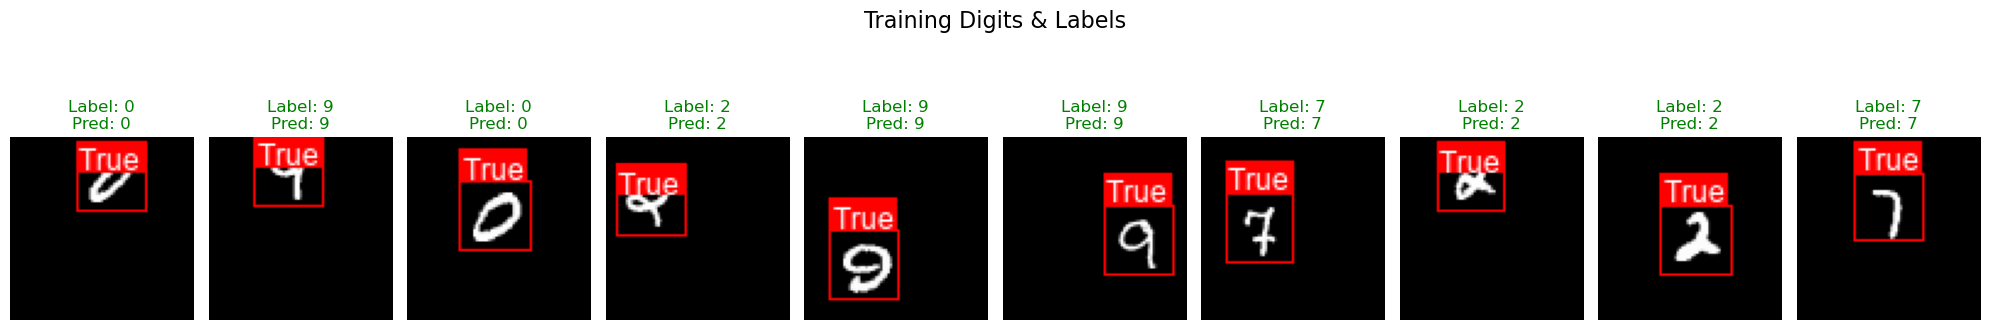

In [724]:
if __name__ == '__main__': 
    with strategy.scope():
        training_dataset = get_training_dataset()
        validation_dataset = get_validation_dataset()

    (training_digits, training_labels, training_bboxes,
     validation_digits, validation_labels, validation_bboxes) = dataset_to_numpy_util(
         training_dataset, validation_dataset, 10 
    )

    
    display_digits_with_boxes(
        digits=training_digits,
        predictions=training_labels, 
        labels=training_labels,
        pred_bboxes=np.array([]),    
        bboxes=training_bboxes,      
        iou=np.array([]),           
        title="Training Digits & Labels"
    )

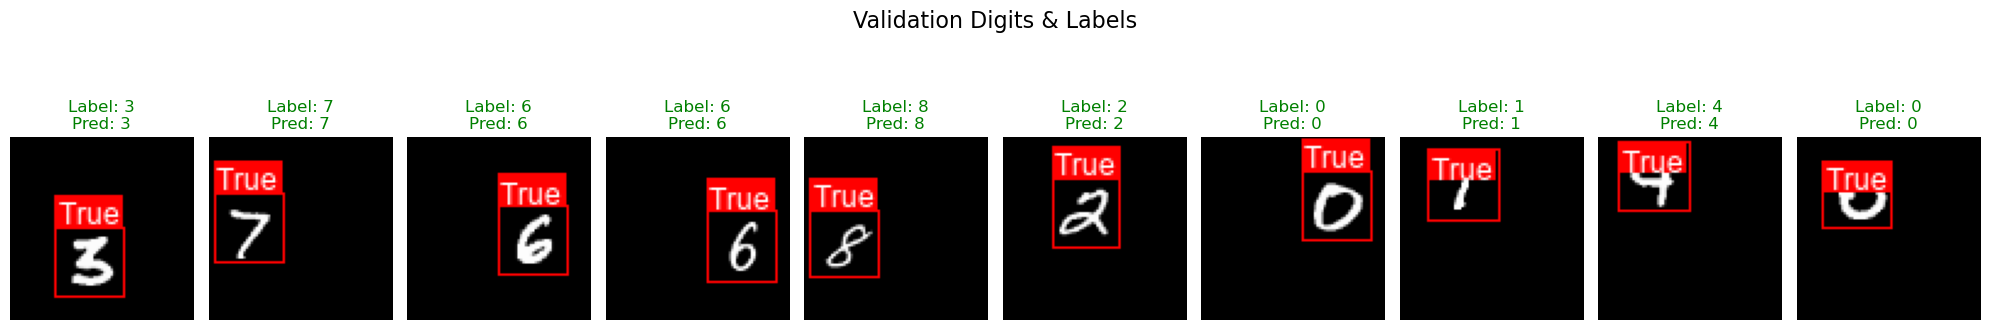

In [728]:
display_digits_with_boxes(
        digits=validation_digits,
        predictions=validation_labels, 
        labels=validation_labels,
        pred_bboxes=np.array([]),    
        bboxes=validation_bboxes,      
        iou=np.array([]),           
        title="Validation Digits & Labels"
    )

Define The Network

In [731]:
def feature_extractor(inputs):
    x = tf.keras.layers.Conv2D(16, activation='relu', kernel_size=3, input_shape=(75,75,1))(inputs)
    x = tf.keras.layers.AveragePooling2D((2,2))(x)

    x = tf.keras.layers.Conv2D(32, activation='relu', kernel_size=3)(x)
    x = tf.keras.layers.AveragePooling2D((2,2))(x)

    x = tf.keras.layers.Conv2D(64, activation='relu', kernel_size=3)(x)
    x = tf.keras.layers.AveragePooling2D((2,2))(x)

    return x

In [733]:
def dense_layers(inputs):
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    return x

In [735]:
def classifier(inputs):
    classification_output= tf.keras.layers.Dense(10, activation="softmax", name = "classification")(inputs)
    return classification_output

In [737]:
def bounding_box_regression(inputs):
    bounding_box_regression_output = tf.keras.layers.Dense(4, name="bounding_box")(inputs)
    return bounding_box_regression_output

In [739]:
def final_model(inputs):
    feature_cnn = feature_extractor(inputs)
    dense_output = dense_layers(feature_cnn)

    classification_output = classifier(dense_output)
    bounding_box_output = bounding_box_regression(dense_output)

    model = tf.keras.Model(inputs = inputs, outputs = [classification_output, bounding_box_output])

    return model

In [741]:
def define_and_compile_model(inputs):
    model = final_model(inputs)

    model.compile(optimizer = 'adam', loss = {'classification' : 'categorical_crossentropy',
                                             'bounding_box': 'mse'},
                 metrics = {'classification': 'accuracy',
                            'bounding_box':'mse'})

    return model

In [743]:
with strategy.scope():
    inputs = tf.keras.layers.Input(shape=(75, 75,1))
    model = define_and_compile_model(inputs)

model.summary()

C:\Users\Kanishk\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)   │ (None, 75, 75, 1)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_30 (Conv2D)            │ (None, 73, 73, 16)        │             160 │ input_layer_12[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ average_pooling2d_26          │ (None, 36, 36, 16)        │               0 │ conv2d_30[0][0]            │
│ (AveragePooling2D)            │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_31 (Conv2D)            │ (None, 34, 34, 32)        │           4,640 │ average_pooling2d_26[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ average_pooling2d_27          │ (None, 17, 17, 32)        │               0 │ conv2d_31[0][0]            │
│ (AveragePooling2D)            │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_32 (Conv2D)            │ (None, 15, 15, 64)        │          18,496 │ average_pooling2d_27[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ average_pooling2d_28          │ (None, 7, 7, 64)          │               0 │ conv2d_32[0][0]            │
│ (AveragePooling2D)            │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_8 (Flatten)           │ (None, 3136)              │               0 │ average_pooling2d_28[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_8 (Dense)               │ (None, 128)               │         401,536 │ flatten_8[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classification (Dense)        │ (None, 10)                │           1,290 │ dense_8[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bounding_box (Dense)          │ (None, 4)                 │             516 │ dense_8[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 426,638 (1.63 MB)

 Trainable params: 426,638 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

Train & Validate The Model

In [664]:
EPOCHS = 20
steps_per_epoch = 60000 //BATCH_SIZE
validation_steps = 1

history = model.fit(training_dataset, steps_per_epoch = steps_per_epoch,
                   validation_data=validation_dataset, validation_steps=1, epochs=EPOCHS)

loss , classification_loss, bounding_box_loss , classification_acc, bounding_box_mse=model.evaluate(validation_dataset, steps =1)
print("\n-----------------------------------\n")
print("validation Accuracy:", classification_acc)
print("\n-----------------------------------\n")

Epoch 1/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 35s 31ms/step - bounding_box_loss: 0.0234 - bounding_box_mse: 0.0234 - classification_accuracy: 0.4433 - classification_loss: 1.5177 - loss: 1.5412 - val_bounding_box_loss: 0.0129 - val_bounding_box_mse: 0.0129 - val_classification_accuracy: 0.9100 - val_classification_loss: 0.2912 - val_loss: 0.3041
Epoch 2/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 27s 29ms/step - bounding_box_loss: 0.0085 - bounding_box_mse: 0.0085 - classification_accuracy: 0.9087 - classification_loss: 0.3006 - loss: 0.3091 - val_bounding_box_loss: 0.0046 - val_bounding_box_mse: 0.0046 - val_classification_accuracy: 0.9410 - val_classification_loss: 0.1853 - val_loss: 0.1899
Epoch 3/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 26s 28ms/step - bounding_box_loss: 0.0041 - bounding_box_mse: 0.0041 - classification_accuracy: 0.9408 - classification_loss: 0.1974 - loss: 0.2015 - val_bounding_box_loss: 0.0029 - val_bounding_box_mse: 0.0029 - val_classification_accuracy: 0.9540 - val_classification_loss: 

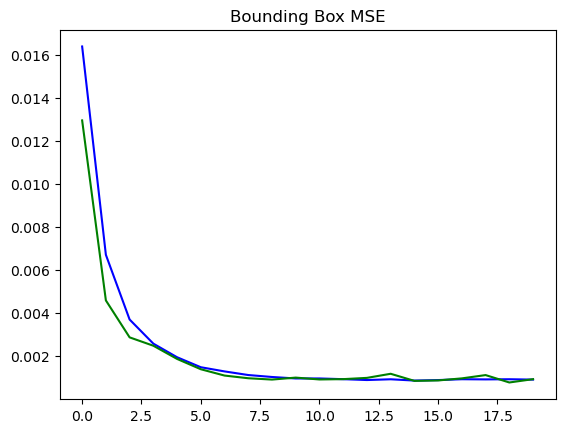

In [746]:
plot_metrics("bounding_box_mse", "Bounding Box MSE")

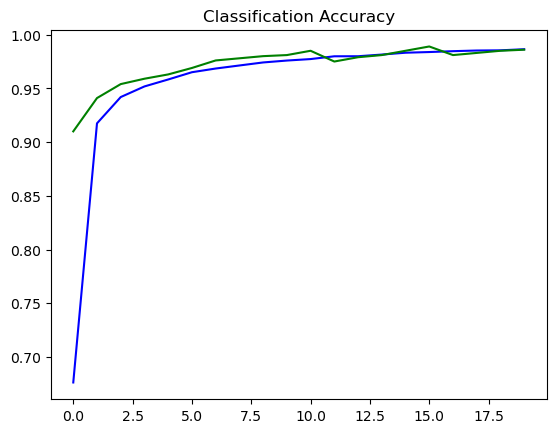

In [748]:
plot_metrics("classification_accuracy", "Classification Accuracy")

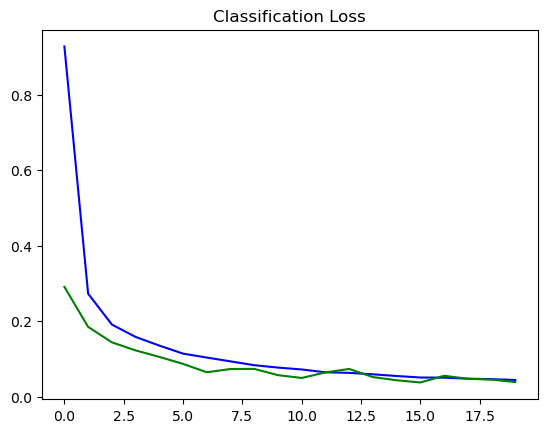

In [750]:
plot_metrics("classification_loss", "Classification Loss")

In [762]:
def intersection_over_union(pred_box, true_box):
    xmin_pred , ymin_pred, xmax_pred, ymax_pred = np.split(pred_box, 4, axis =1)
    xmin_true , ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis =1)

    smoothing_factor = 1e-10
    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.maximum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.maximum(ymax_pred, ymax_true)

    pred_box_area = (xmax_pred-xmin_pred)*(ymax_pred-ymin_pred)
    true_box_area = (xmax_true-xmin_true)*(ymax_true-ymin_true)

    overlap_area = np.maximum((xmax_overlap-xmin_overlap),0)*np.maximum((ymax_overlap-ymin_overlap),0)
    union_area = (pred_box_area+true_box_area)- overlap_area

    iou = (overlap_area+ smoothing_factor)/(union_area+smoothing_factor)
    return iou

In [766]:
prediction = model.predict(validation_digits , batch_size = 64)

predicted_labels = np.argmax(prediction[0] , axis = 1)

prediction_bboxes = prediction[1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


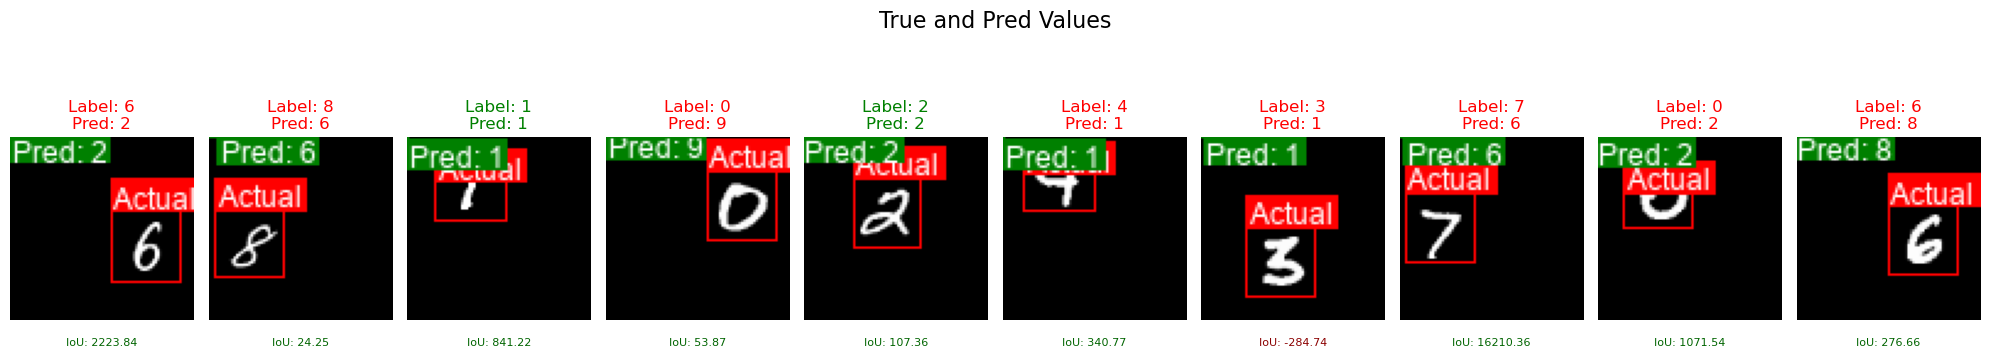

In [774]:
iou = intersection_over_union(prediction_bboxes, validation_bboxes)

iou_threshold = 0.6

display_digits_with_boxes(validation_digits, predicted_labels, validation_labels,
                         prediction_bboxes, validation_bboxes, iou , "True and Pred Values")